# Sirepo Machine Learning Tutorial: Predicting the e- beam Longitudinal Phase Space from Elegant Simulations of the LCLS


*NAPAC'19 Sirepo Users Workshop (September 3, 2019)*

**Developed by Auralee Edelen (SLAC), Christopher Hall (RadiaSoft), adapted to LCLS-ii by Adi Hanuka (SLAC), and Claudio Emma (SLAC)**  
Elegant simulation of LCLS adapted from work by Yuantao Ding (SLAC)
<pre>

</pre>
---------

# Introduction

The aim of this tutorial is to show one example of how machine learning can be used to predict beam parameter output in an accelerator system. 

Although we give some very basic tips along the way, this is not meant to be a pedagogical introduction to machine learning (for that and associate hands-on notebooks with toy accelerator problems see the ICFA ML tutorials: https://indico.psi.ch/event/6698/sessions/3632/#20190226).

Here, we run an elegant simulation of the LCLS with phase and amplitude jitter in L1 and produce the resultant e- beam phase space at the end of BC1 or BC2.
<pre>

</pre>
<img src="lcls.png" width="800"> 
<pre>

</pre>
<img src="lclslps.png" width="800">

---------



# Setup
Designed to run at jupyter.radiasoft.org, with Python 2 kernel.

*The advantage of running on RadiaSoft's jupyterhub is that they have a suite of accelerator simulation tools and Python packages pre-installed. If running this notebook elsewhere, you'll need to install elegant, SDDS, and the required Python packages.*


Required files to have in your directory:
- elegant.lte
- error_elegant.ele
- SDDS.py
- utilities.py
- utilities3.py
- four wakefield files ("Sx_ ..., Sz_ ...")
- initial bunch ("OTR2_100pCresc420um_matchSM.out")


In [39]:
#import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import physical_constants
from SDDS import readSDDS
m_e = physical_constants["electron mass energy equivalent in MeV"][0]
from utilities3 import error_scan, lps_plot
from utilities import read_settings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, GaussianNoise
from mlhelpers4 import PlotLosses, plot_a_bunch_of_beams,make_dataset
plot_losses=PlotLosses()
import time

<pre>

</pre>
---------
# Create Training Data - Jitter in Linac Phases and Amplitudes
## *(or skip if you want to just load the pre-made output file)*

The training data simulates the impact of jitter in the linac phases and amplitudes. The data is generated by imposing random errors, with a Gaussian distribution, on phase and amplitude in the L1 linac section. The first run is a fiducializing step that uses the exact linac settings.
- `data_points`: Number of times to run.
- `phase_error`: The width of the Gaussian distribution of error in the L1 phase settings. This is an absolute error in units of Degrees.
- `amplitude_error`: The wdith of the Guassian distribution of error in the L1 amplitude (Voltage) setting. This is a fractional error based on the default Voltage setting.

You can choose some range of setting errors and number of points to sample, but use the nominal values first.

More data is not always better -- we need to avoid oversampling the space, which would make our training set look identical to our validation and testing sets.
</p>
</details>


In [40]:
make_data = True

if make_data == True:
    # Scan settings
    data_points = 1000              # nominal: 1000
    phase_error_setting = 0.03      # nominal: 0.03
    amplitude_error_setting = 0.02  # nominal: 0.02
    lattice_name = 'BC2LINE'        # nominal: BC2LINE, may be BC1LINE or BC2LINE

    # Run scan in elegant
    t1=time.time()
    error_scan(max_iter=data_points, 
               phase_error=phase_error_setting, 
               amplitude_error=amplitude_error_setting,
               lattice=lattice_name)
    print(str('simulations took ' + str(np.round(((time.time()-t1)/60),2))+ ' mins'))

100% (1000 of 1000) |####################| Elapsed Time: 0:01:11 ETA:  00:00:00

simulations took 1.22 mins


## Read Training Data from File

### *Load Phase Space Data*

In [3]:
ff = readSDDS('run_setup.output.sdds')
parameters, bunches = ff.read()
print('particles in bunch ', bunches.shape[1])

particles in bunch  988


In [41]:
bunches.shape[0]

250

### *Load Machine Settings*

In [4]:
settings = read_settings('error.log')
settings_array=np.asarray(settings,dtype='float')

### *Data Exploration*

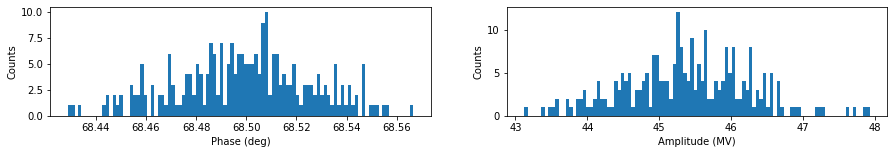

In [5]:
plt.figure(figsize=(15,2))
plt.subplot(1,2,1)
plt.hist(settings_array[:,0],bins=100)
plt.xlabel('Phase (deg)')
plt.ylabel('Counts')
           
plt.subplot(1,2,2)
plt.hist(settings_array[:,3]/(10**6),bins=100)
plt.xlabel('Amplitude (MV)')
plt.ylabel('Counts')
plt.show()


Plot longitudinal phase space data at the end of the beamline. The settings changed by errors are displayed in a table.

In [6]:
plot = lps_plot(bunches, settings)
plot()

interactive(children=(IntText(value=0, description='step'), Output()), _dom_classes=('widget-interact',))

<pre>

</pre>
---------
# Format and Plot Training Data

### *choose how to bin the data and convert it to images and profiles*

This bins the particle data and then calculates the following:

* histogram (*'h'*)
* the energy profile (*'yprof'*)
* the time profile (*'xprof'*)
* and the x and y extent (*'xedges'*, *'yedges'*)

In [7]:
nbins = 60 #number of bins to use, nominal: 60
h,xprof,yprof,xedges,yedges = make_dataset(bunches,nbins)

### *Plot the Energy and Bunch Duration Profiles*

In [8]:
def plot_profiles(xprof,yprof,xedges,yedges,numb):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    
    for i in range(0,numb):
        idx = np.random.randint(0,xprof.shape[0])
        plt.plot(xedges[0:-1],xprof[idx,:])
        plt.xlabel('Position (ps)',size=14)
        plt.ylabel('Counts (arb.)',size=14)
    plt.subplot(1,2,2)
    
    for i in range(0,numb):
        idx = np.random.randint(0,yprof.shape[0])
        plt.plot(yedges[-1:0:-1]/1000.0,yprof[idx,:])
        plt.xlabel('Energy (GeV)',size=14)
        plt.ylabel('Counts (arb.)',size=14)
    plt.show()

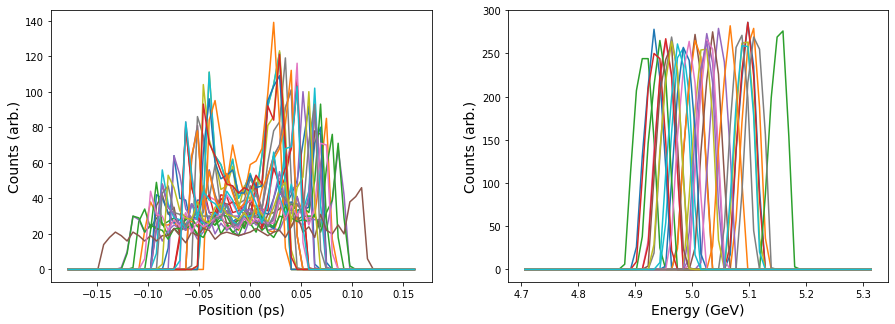

In [9]:
plot_profiles(xprof,yprof,xedges,yedges,30)

### *Plot the Beam Image*

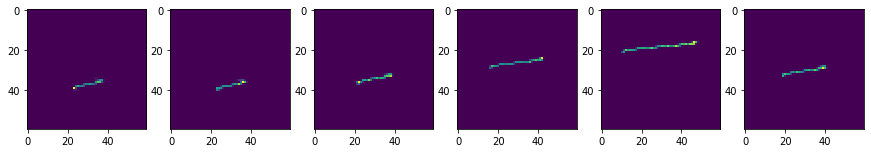

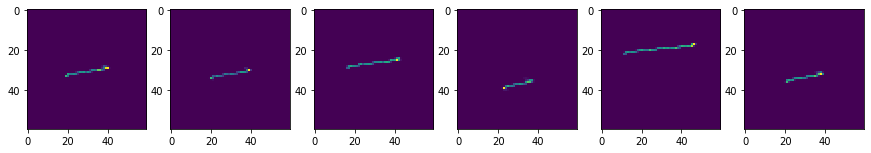

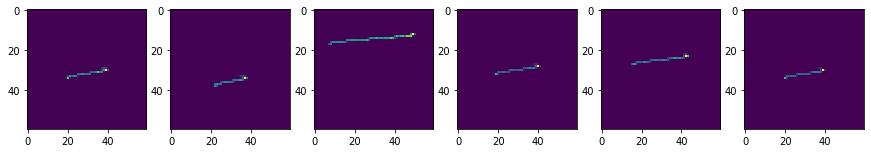

In [10]:
plot_a_bunch_of_beams(h,bunches,nbins)

<pre>

</pre>
---------
# Machine Learning
## First Let's Predict Some Scalar Outputs

### *calculate scalars of interest*

We'll use the following as initial target data:

* energy spread ('delta_E')
* average energy ('avg_E')
* bunch duration ('bunch_dur')

In [11]:
# calculate scalar beam parameters
avg_E = np.average(bunches[:,:,5]*m_e,axis=1)
delta_E = np.std(bunches[:,:,5]*m_e,axis=1)
bunch_dur = np.std(bunches[:,:,4],axis=1)

In [12]:
# set X and Y training data
X = np.asarray(settings)
Y = np.concatenate((avg_E.reshape(avg_E.shape[0],1),delta_E.reshape(delta_E.shape[0],1),bunch_dur.reshape(bunch_dur.shape[0],1)),axis=1)

### *scale data*
With raw data in hand, first we'll want to **scale our data to a range that's appropriate for the algorithm we're using.** In this case, we'll use [-1,1] since we're using a neural network with tanh activation functions.


In [13]:
# scale training data into range -1,1
transformer_x = MinMaxScaler(feature_range=(-1, 1)).fit(X)
transformer_y = MinMaxScaler(feature_range=(-1, 1)).fit(Y)
x = transformer_x.transform(X)
y = transformer_y.transform(Y)

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### *split data*

<details>
<summary>
<i> more explanation  </i>
</summary>
<p>

We need to **divide the data into training, validation, and testing sets:**
* **Training data**: This is the data that is used to update the weights. <br />
* **Validation data**: This data is not used to update the weights, but it is used during the training/model selection process to see how well a given model generalizes. This will help one decide between different ML model types to use, training algorithms to use, and sets of hyperparameters (e.g. the learning rate, the number of layers in a NN). It also is used to inform the user when the network is starting to overfit the data during training. <br />
* **Testing data**: This data is not used at all during training and is used to assess the final performance of the model.
    
It is also very important to make sure that we have **avoided oversampling** the space and made our training set look identical to our test set (despite the random split).
    
A split of 60 percent training, 20 percent validation, and 20 percent testing is common.
</p>
</details>

In [14]:
# split training data into train, validation, and test sets
train_percent=60
x_train, x_tv, y_train, y_tv = train_test_split(x, y, test_size=(100-train_percent)/100.0, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tv, y_tv, test_size=0.50, random_state=42)

### *define model*

<details>
<summary>
<i> more explanation  </i>
</summary>
<p>

The number of nodes and layers, as well as the activation function determine the neural network architecture.
The loss function determines what error metric to use for training.
These are all "hyperparameters" that can be adjusted to improve network performance.
The optimization algorithm and its hyperparameters (e.g. initial learning rate, momentum value) can also be adjusted.
See the Keras documentation for more detail on the various options: https://keras.io/.
</p>
</details>

In [15]:
# Make Neural Network model in Keras

layersizes = [8,8,8,8]   # Nominal: [8,8,8,8], nodes in each layer
activations = 'tanh'     # Nominal: 'tanh'

model = Sequential()
model.add(Dense(layersizes[0],activation=activations))
model.add(Dense(layersizes[1],activation=activations))
model.add(Dense(layersizes[2],activation=activations))
model.add(Dense(layersizes[3],activation=activations))
model.add(Dense(y_train.shape[1],activation='linear'))
model.compile(loss='mean_squared_error',
              optimizer='adam')

### *train model*

<details>
<summary>
<i> more explanation  </i>
</summary>
    
    
The **batch size** determines how many individual samples are used to compute one update to all the weights. When you set "shuffle = true" the points from the data set are chosen randomly for each batch. Keras makes sure that every training example is seen once during each **epoch**.

When training, monitor the validation loss curve and training loss curve. If the validation loss starts to increase for awhile but the training loss continues to decrease, it means you're starting to overfit.

Examples of overfitting (left) and a normal loss curve (right)

<img src="overfit.png" width="300"> <img src="not_overfit.png" width="300"> 

First steps to combat overfitting:
* choose a smaller network architecture
* add regularization (e.g. noise, l2 penalty on weights)
* increase data set size (but make sure there's enough variety in it to avoid oversampling!)

</details>

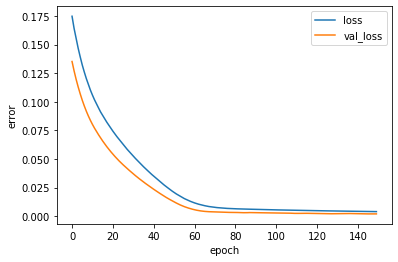

In [16]:
# fit model
hist = model.fit(x = x_train, y = y_train,
                 validation_data = (x_val,y_val),
                 batch_size = 100, 
                 shuffle = 'true',
                 epochs = 150, 
                 verbose = 'false', 
                 callbacks=[plot_losses])

### *examine model performance*

We'll take a look at the performance on the validation data set. The test set should be completely unseen during the process of selecting and training a model.

In [17]:
#specify set to look at and make prediction
set_to_look=[x_val,y_val]
y_pred=model.predict(set_to_look[0])

#change to full scale
Y_pred=transformer_y.inverse_transform(y_pred)
Y_true=transformer_y.inverse_transform(set_to_look[1])
X_inputs=transformer_x.inverse_transform(set_to_look[0])

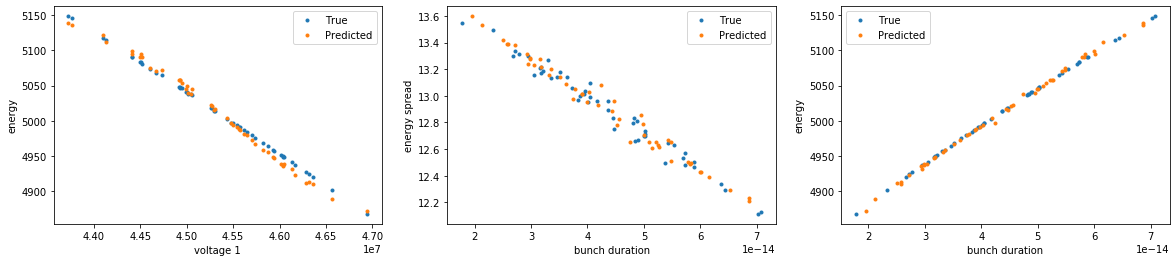

In [18]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(X_inputs[:,3],Y_true[:,0],'.')
plt.plot(X_inputs[:,3],Y_pred[:,0],'.')
plt.legend(['True', 'Predicted'])
plt.xlabel('voltage 1')
plt.ylabel('energy')

plt.subplot(1,3,2)
plt.plot(Y_true[:,2],Y_true[:,1],'.')
plt.plot(Y_pred[:,2],Y_pred[:,1],'.')
plt.legend(['True', 'Predicted'])
plt.xlabel('bunch duration')
plt.ylabel('energy spread')

plt.subplot(1,3,3)
plt.plot(Y_true[:,2],Y_true[:,0],'.')
plt.plot(Y_pred[:,2],Y_pred[:,0],'.')
plt.xlabel('bunch duration')
plt.ylabel('energy')
plt.legend(['True', 'Predicted'])
plt.show()

## Let's predict the current profiles

In [19]:
X = np.asarray(settings)
Y = xprof

Text(0, 0.5, 'counts')

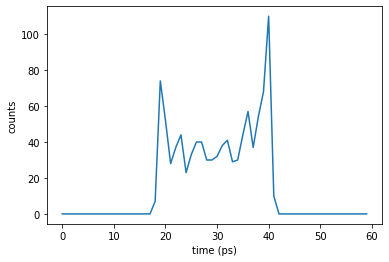

In [20]:
plt.plot(xedges[0:-1],Y[10,:])
plt.xlabel('time (ps)')
plt.ylabel('counts')

### *scale data*

In [21]:
transformer_x = MinMaxScaler(feature_range=(-1, 1)).fit(X)
#transformer_y = MinMaxScaler(feature_range=(-1, 1)).fit(Y)
x = transformer_x.transform(X)
y = y=Y/np.max(Y)

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### *split data*

In [22]:
# split training data into train, validation, and test sets
train_percent=60
x_train, x_tv, y_train, y_tv = train_test_split(x, y, test_size=(100-train_percent)/100.0, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tv, y_tv, test_size=0.50, random_state=42)

### *make model and train*

In [25]:
# Make model
ysz = y.shape[1]
layersizes = [ysz*2,ysz*2,ysz*2,ysz*3,ysz*3]   # Nominal: [ysz*2,ysz[1]*2,ysz[1]*2,ysz[1]*3,ysz[1]*3] 
activations = 'relu'                                       # Nominal: 'relu' 

model = Sequential()
model.add(Dense(layersizes[0],activation=activations))
model.add(Dense(layersizes[1],activation=activations))
model.add(Dense(layersizes[2],activation=activations))
model.add(Dense(layersizes[3],activation=activations))
model.add(Dense(layersizes[4],activation=activations))
model.add(Dense(y.shape[1],activation='linear'))
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mae'])

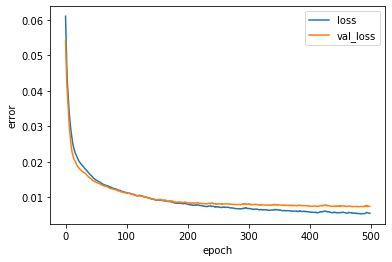

In [26]:
hist = model.fit(x_train, y=y_train, validation_data = (x_val,y_val),batch_size = 100, shuffle = 'true',epochs = 500, verbose = 'false', callbacks=[plot_losses])

### *examine model performance*

In [27]:
#specify set to look at and make prediction
set_to_look=[x_val,y_val]
y_pred=model.predict(set_to_look[0])

#change to full scale
Y_pred=y_pred*np.max(Y)
Y_true=set_to_look[1]*np.max(Y)
X_inputs=transformer_x.inverse_transform(set_to_look[0])

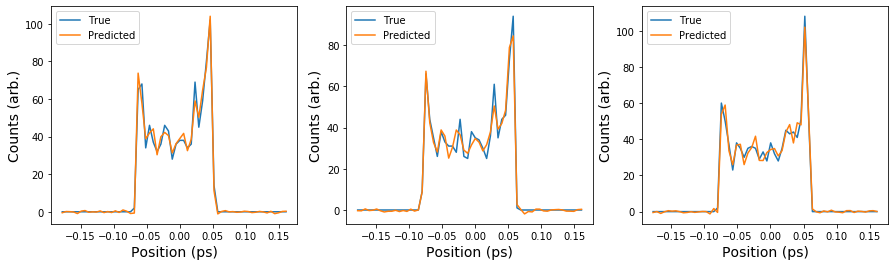

In [28]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
idx=np.random.randint(0,set_to_look[1].shape[0])
plt.plot(xedges[0:-1],Y_true[idx,:])
plt.plot(xedges[0:-1],Y_pred[idx,:])

plt.legend(['True', 'Predicted'])
plt.xlabel('Position (ps)',size=14)
plt.ylabel('Counts (arb.)',size=14)
plt.subplot(1,3,2)

idx=np.random.randint(0,set_to_look[1].shape[0])
plt.plot(xedges[0:-1],Y_true[idx,:])
plt.plot(xedges[0:-1],Y_pred[idx,:])
plt.legend(['True', 'Predicted'])
plt.xlabel('Position (ps)',size=14)
plt.ylabel('Counts (arb.)',size=14)

plt.subplot(1,3,3)
idx=np.random.randint(0,set_to_look[1].shape[0])
plt.plot(xedges[0:-1],Y_true[idx,:])
plt.plot(xedges[0:-1],Y_pred[idx,:])
plt.legend(['True', 'Predicted'])
plt.xlabel('Position (ps)',size=14)
plt.ylabel('Counts (arb.)',size=14)
plt.show()

## Exercise: Overfitting

Change the number of samples used in the profile prediction to 100 and repeat the profile prediction example

In [29]:
indices=np.random.randint(0,settings.shape[1],100)
X = np.asarray(settings)[indices,:]
Y = xprof[indices,:]

Add in the profile prdiction code from the section above.

After seeing the overfitting, try adding GaussianNoise layers to the model.

## Exercise: Set up the same model for the energy profile 

Add your code here

## Bonus Exercise: Uncertainty Estimation and Gaussian Processes

Gaussian Process models can be used to provide an estimate of prediction uncertainty. Based on the IFCA tutorials on Gaussian Processes, add some noise to the scalar output training data from the first section and try to make a gaussian process to predict the scalar beam parameters (e.g. energy spread, etc.).

## Bonus Exercise: Direct Image Prediction

In [30]:
X = np.asarray(settings)
Y = h

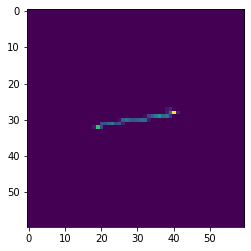

In [31]:
plt.imshow(Y[10,:].reshape((nbins,nbins)));

### *scale data*

In [ ]:
transformer_x = MinMaxScaler(feature_range=(-1, 1)).fit(X)
#transformer_y = MinMaxScaler(feature_range=(-1, 1)).fit(Y)
x = transformer_x.transform(X)
y = Y/np.max(Y)

### *split data*

In [ ]:
# split training data into train, validation, and test sets
train_percent=60
x_train, x_tv, y_train, y_tv = train_test_split(x, y, test_size=(100-train_percent)/100.0, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tv, y_tv, test_size=0.50, random_state=42)

### *make model and train*

Try different neural network architectures

In [ ]:
# Make model
# Your code here

In [ ]:
hist = model.fit(x_train, y=y_train, validation_data = (x_val,y_val),batch_size = 100, shuffle = 'true',epochs = 1000, verbose = 'false', callbacks=[plot_losses])

### *examine model performance*

In [ ]:
#specify set to look at and make prediction
set_to_look=[x_val,y_val]
y_pred=model.predict(set_to_look[0])

#change to full scale
Y_pred=y_pred*np.max(Y)
Y_true=set_to_look[1]*np.max(Y)
X_inputs=transformer_x.inverse_transform(set_to_look[0])

In [ ]:
plt.imshow(Y_true[10,:].reshape((nbins,nbins)),vmin=0,vmax=np.max(Y));

In [ ]:
plt.imshow(Y_pred[10,:].reshape((nbins,nbins)),vmin=0,vmax=np.max(Y));